In [78]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np
import matplotlib.pyplot as plt
import cv2

import torch
from torch.autograd import Function
import torchvision
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, IBMQ
from qiskit.aqua.components import optimizers
from qiskit.visualization import *

from scipy.optimize import minimize
from sklearn.preprocessing import normalize


# Background
This code implement [Quantum Autoencoder](https://arxiv.org/abs/1612.02806) as described in the paper

## Choice of Parametrized Quantum Circuit (PQC/Ansatz) architechture
Ansatzs no.6 and no.9 (https://arxiv.org/pdf/1905.10876.pdf) are used with varying number of layers. The architechture has good expressibility and is capable of generating high entanglement.

## Class of Autoencoder
Args:

    n_qubits: number of qubits that store compressed data
    
    k_qubits: number of trash/reference qubits (n+k = number of data qubits)
    
Attributes:

    latent: latent state of n qubits
    
    trash: discarded qubits after encoding
    
    ref: reference qubits (in state '0' by default)
  
Methods:

    initialize_state_from_data(data): create unitary that prepares the (normalized) data sample
    
    insert_PQC(): add PQC architecture to circuit
    
    SWAP_test(): perform SWAP test between trash state and reference state after encoding to measure fidelity
    
    Hadamard_test(): perform Hadamard test between trash state and reference state after encoding to measure state distance
    
    insert_inverse_PQC(): add the inverse of the PQC above
    
    run(thetas): execute the circuit with fixed parameters
    
    draw(): draw the main circuit

In [167]:
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-02-14 21:28:20,051: Credentials are already in use. The existing account in the session will be replaced.


In [94]:
class AutoencoderQuantumCircuit():
    """ 
    This class provides an interface for interaction 
    with the quantum autoencoder
    
    Args:
        n_qubits : int
        Number of qubits that store compressed data (latent space size)
        
        k_qubits : int
        Number of trash qubits
        
        layers : int
        Number of ansatz layers
        
        ansatz_id: int
        ID number of the ansatz according to [paper]
        
        backend : qiskit.providers.Backend
        Type of backend for executing circuit
        
        shots : int
        Number of experiment trials
        
    """
    
    def __init__(self, n_qubits, k_qubits, layers,
                 #ansatz_id=None,
                 backend=provider.get_backend("ibmq_qasm_simulator"), shots=1000):
        '''
        Initialize self circuit
        '''
        ## Basic attributes
        self.k_qubits = k_qubits
        self.n_qubits = n_qubits
        self.layers = layers
        self.data_qubits = list(range(self.n_qubits + self.k_qubits))
        
        ## PQC attributes
        self.theta = None
        self._PQC = None
        
        ## Reconstruction attributes
        self._recon_ref = None
        self._data_cr = None
        self._PQC_inverse = None
        
        ## SWAP attribute
        self._ref = None
        self._test_ancilla = None
        self._test_cr = None    

        ## Experiment attributes
        self.backend = backend
        self.shots = shots
                
        # --- Circuit definition ---
        self._latent = QuantumRegister(self.n_qubits, name='latent')
        self._trash = QuantumRegister(self.k_qubits, name='trash')
        self._circuit = QuantumCircuit(self._latent, self._trash)
        
    def initialize_state_from_data(self,init_data, return_initializer=False):
        '''
        Initialize a quantum state that corresponds to the data sample. The data must be in 1-D numpy array.
        The initializer circuit is stored in self._initializer
        
        Args:
            init_data : np.array
            Quantum state to initialize
            
            return_initializer : bool, optional
            Additionally return an initializer object
        '''
        if init_data is None:
            return
        
        assert type(init_data) == np.ndarray, "Initial data should be a numpy array."
        
        # Normalized vector
        desired_vector = init_data[:]
        desired_vector = desired_vector / np.linalg.norm(desired_vector)
        
        self._initializer = QuantumCircuit(len(self.data_qubits), name='amplitude_encoder')
        self._initializer.initialize(desired_vector, self._initializer.qregs)
        #self._circuit.append(self._initializer.to_instruction(), self._latent[:] + self._trash[:])
        #self.draw()
        #self._circuit.initialize(desired_vector, [self._latent, self._trash])       
        if return_initializer == True:
            return qiskit.extensions.Initialize(desired_vector)
        return
    
    def create_PQC(self, ansatz_id=None):
        '''
        Implement PQC architectures in the following paper:
        '''
        if ansatz_id is None:
            ansatz_id = 9
        width = len(self.data_qubits)
        self._PQC = QuantumCircuit(width)
        
        if ansatz_id == 6:      
            num_params = (width*width + 3*width) * self.layers
            self.theta = qiskit.circuit.ParameterVector('θ', num_params)
            theta_iter = iter(self.theta)     

            for layer in range(self.layers):
                for i in self.data_qubits:
                    self._PQC.rx(next(theta_iter), i)
                for i in self.data_qubits:
                    self._PQC.rz(next(theta_iter), i)

                for i in self.data_qubits:
                    for j in self.data_qubits:
                        if j != i:
                            self._PQC.crx(next(theta_iter), i, j)

                for i in self.data_qubits:
                    self._PQC.rx(next(theta_iter), i)
                for i in self.data_qubits:
                    self._PQC.rz(next(theta_iter), i)    
                     
        elif ansatz_id == 9:
            num_params = width * self.layers
            self.theta = qiskit.circuit.ParameterVector('θ', num_params)
            theta_iter = iter(self.theta) 
            
            for layer in range(self.layers):
                self._PQC.h(self.data_qubits)
                for i in self.data_qubits[:-1]:
                    self._PQC.cz(i,i+1)
                for i in self.data_qubits:
                    self._PQC.rx(next(theta_iter), i)
            
        #print("PQC PQC circuit = ")
        #print(self._PQC.draw())
        
        self._PQC_gate = self._PQC.to_gate(label='PQC gate') 
        
        return 
            
    def SWAP_test(self, init_data=None, thetas=None, ansatz_id=None):
        
        #print("SWAP ansatz_id = {}".format(ansatz_id))
        
        self._ref = QuantumRegister(self.k_qubits, name='ref')
        self._test_ancilla = QuantumRegister(1, name='testancilla')
        self._test_cr = ClassicalRegister(1, name='testmeasure')
        self._circuit.add_register(self._ref, self._test_ancilla, self._test_cr)
        
        ## Prepare data
        #print("SWAP init_data = {}".format(init_data))
        self.initialize_state_from_data(init_data)
        self._circuit.append(self._initializer.to_instruction(), self._latent[:] + self._trash[:])
        
        ## Prepare PQC structure
        self.create_PQC(ansatz_id)
        self._circuit.append(self._PQC_gate, self._latent[:] + self._trash[:]) 
        
        ## Set up SWAP test
        self._circuit.h(self._test_ancilla)
        for i in range(len(self._trash)):
            self._circuit.cswap(self._test_ancilla, self._trash[i], self._ref[i])
        self._circuit.h(self._test_ancilla)
        self._circuit.measure(self._test_ancilla, self._test_cr)
        #self.draw()
        
        ## EXECUTE SWAP TEST
        probabilities = self.run(thetas)
        #print("SWAP probabilities = {}".format(probabilities))
        
        for prob in probabilities:
            if '0' not in prob:
                prob['0'] = 0
            if '1' not in prob:
                prob['1'] = 0
                
        calculate_f = lambda prob: prob['0'] - prob['1']
        fidelities = np.array(list(map(calculate_f, probabilities)))
        
        return fidelities
    
    def Hadamard_test(self, init_data=None, thetas=None, ansatz_id=None):
        self._ref = QuantumRegister(self.k_qubits, name='ref')
        self._test_ancilla = QuantumRegister(1, name='testancilla')
        self._test_cr = ClassicalRegister(1, name='testmeasure')
        self._discard = ClassicalRegister(self.n_qubits, name='testdiscard')
        self._circuit.add_register(self._ref, self._test_ancilla, self._test_cr, self._discard)   
        
        self._circuit.h(self._test_ancilla)
        
        ## Prepare controlled data initializer
        initializer =  self.initialize_state_from_data(init_data, return_initializer=True)     
        controlled_initializer = initializer.gates_to_uncompute().decompose().decompose().inverse().to_gate(label='amplitude_encoder').control()
        self._circuit.append(controlled_initializer, self._test_ancilla[:] + self._latent[:] + self._trash[:])
        
        ## Prepare controlled PQC
        self.create_PQC(ansatz_id)
        control_PQC = self._PQC_gate.control()
        self._circuit.append(control_PQC, self._test_ancilla[:] + self._latent[:] + self._trash[:]) 
        
        self._circuit.h(self._test_ancilla)
        
        self._circuit.measure(self._latent, self._discard)
        self._circuit.measure(self._test_ancilla, self._test_cr)
        #self.draw()
        
        ## EXECUTE HADAMARD TEST
        probabilities = self.run(thetas)
        #print("Hadamard probabilities = {}".format(probabilities))

        #calculate_distance = lambda prob: sum([val for key,val in prob.items() if key[-1]=='0']) - sum([val for key,val in prob.items() if key[-1]=='1']) 
        calculate_distance = lambda prob: sum([val * (-1)**int(key[-1]) for key,val in prob.items()])
        fidelities = np.array(list(map(calculate_distance, probabilities)))
        
        return fidelities
        
        
    def insert_inverse_PQC(self):
        #self._PQC_gate =
        self._recon_ref = QuantumRegister(self.k_qubits, name='reconref')
        self._data_cr = ClassicalRegister(len(self.data_qubits))
        self._circuit.add_register(self._recon_ref, self._data_cr)
        
        self._PQC_inverse = self._PQC_gate.inverse()
        self._PQC_inverse.label = 'PQC_dg'
        self._circuit.append(self._PQC_inverse, self._latent[:] + self._recon_ref[:])
        #self._circuit.measure(self._latent[:] + self._recon_ref[:], self._data_cr)
        return
    
    def reconstruct(self, init_data, theta, ansatz_id=None):
        
        ## Prepare data and PQC architecture
        #print("SWAP init_data = {}".format(init_data))
        self.initialize_state_from_data(init_data)
        self._circuit.append(self._initializer.to_instruction(), self._latent[:] + self._trash[:])
        
        self.create_PQC(ansatz_id)
        self._circuit.append(self._PQC_gate, self._latent[:] + self._trash[:])        
        self.insert_inverse_PQC()
        
        self._circuit.measure(self._latent[:] + self._recon_ref[:], self._data_cr)
        self.draw()
        print(theta)
        probabilities = self.run([theta])
        return probabilities
    
    def run(self, thetas=None):
        
        if thetas is not None:
            #thetas = [thetas]
            #print("RUN thetas shape = {}".format(np.array(thetas).shape))
            bound_circuits = [self._circuit.bind_parameters({self.theta: theta}) for theta in thetas]
            
        else:
            bound_circuits = [self._circuit]
        #print(bound_circuits[0].draw())
            
        job = qiskit.execute(bound_circuits,
                             backend = self.backend,
                             shots = self.shots)

        #bin_convert = lambda bitstring: int(bitstring.replace(" ", ""), 2)
        probabilities = []
        
        for idx,circuit in enumerate(bound_circuits):
            #print(circuit.draw())
            result = job.result().get_counts(idx)
            
            prob = {state:count/self.shots for state,count in result.items()}
            probabilities.append(prob)
        #print("RUN probabilities = {}".format(probabilities))
        self.reset_circuit()
        #print("RUN reset")
        return np.array(probabilities)
            

    def draw(self):
        print(self._circuit.draw())
        
    def measure(self, thetas=None, scope='all'): 
        if scope == 'all':
            n = self._circuit.num_qubits
            measure_cr = ClassicalRegister(n)
            self._circuit.add_register(measure_cr)
            self._circuit.measure(self._circuit.qubits, measure_cr)
            probabilities = self.run(thetas)
        if scope == 'latent':
            n = self.n_qubits
            measure_cr = ClassicalRegister(n)
            self._circuit.add_register(measure_cr)
            self._circuit.measure(self._circuit.qubits[:n], measure_cr)
            probabilities = self.run(thetas)
        return probabilities
    
    def reset_circuit(self):
        self._circuit = QuantumCircuit(self._latent, self._trash)
        return
    

In [165]:
## TESTING
simulator = qiskit.Aer.get_backend('qasm_simulator')
shots=100000
data = np.zeros(shape=16) # Array of size 16 --> 4 qubits
data[0]= 1

t1 = [0]*4
t2 = [1]*4
thetas = [t1,t2]

circuit = AutoencoderQuantumCircuit(2,2,1, backend=simulator, shots=shots)
fidelities = circuit.SWAP_test(data,thetas,9)

print(fidelities)

[0.24594 0.25172]


## Loss function
Loss := 1 - AverageFidelity, where AverageFidelity is the (uniform) mean of fidelities between trash/reference of all data samples

In [43]:
def loss_function(parameters, train_data, n_qubits, k_qubits, layers, backend, shots):
    global opt
    
    n_samples = len(train_data)
    avg_fidelity = 0
    parameters = [parameters]
    for sample in train_data:
        circuit = AutoencoderQuantumCircuit(n_qubits, k_qubits, layers, backend, shots)
#         circuit.initialize_state_from_data(sample)
#         circuit.insert_PQC()
#         print("SWAPPING")
        fidelity = circuit.SWAP_test(sample,parameters)[0]
        
        avg_fidelity += fidelity / n_samples
    print(1-avg_fidelity)
    return 1-avg_fidelity

### Training on a trivial dataset

[0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]


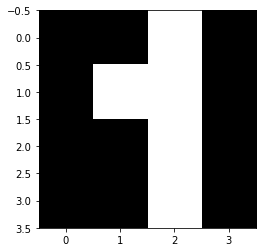

In [59]:
train_data_mini_1 = np.zeros(16)
train_data_mini_1[2] = 1
train_data_mini_1[6] = 1
train_data_mini_1[10] = 1
train_data_mini_1[14] = 1
train_data_mini_1[5] = 1
print(train_data_mini_1)
plt.imshow(train_data_mini_1.reshape(4,4), cmap='gray')

[0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0.]


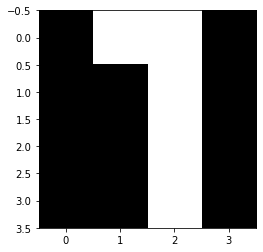

In [65]:
train_data_mini_2 = np.zeros(16)
train_data_mini_2[2] = 1
train_data_mini_2[6] = 1
train_data_mini_2[10] = 1
train_data_mini_2[14] = 1
train_data_mini_2[1] = 1
print(train_data_mini_2)
plt.imshow(train_data_mini_2.reshape(4,4), cmap='gray')

In [149]:
train_data_mini = [train_data_mini_1, train_data_mini_2]

In [159]:
optimizer = optimizers.COBYLA()
n_qubits = 2
k_qubits = 2
layers = 5
backend = qiskit.Aer.get_backend('qasm_simulator') #provider.get_backend('ibmq_qasm_simulator')
shots = 1000

data_dim = n_qubits + k_qubits
num_params = data_dim*layers

np.random.seed(20)
init_params = np.random.rand(num_params,) * 0.01

# out = minimize(loss_function, x0=init_params, method="COBYLA", tol=1.e-6,
#                args=(train_data_mini,n_qubits,k_qubits,layers,backend,shots),
#                options={'maxiter':400})

opt_params,opt_loss,_ = optimizer.optimize(num_params, 
                                           optimizers.COBYLA.wrap_function(loss_function,args=(train_data_mini,n_qubits,k_qubits,layers,backend,shots)), 
                                           initial_point=init_params)

1.024
0.8170000000000001
0.725
0.722
0.707
0.706
0.633
0.644
0.63
0.6379999999999999
0.605
0.6719999999999999
0.571
0.62
0.595
0.593
0.607
0.608
0.622
0.695
0.7190000000000001
0.797
0.65
0.382
0.474
0.375
0.577
0.376
0.278
0.28
0.4620000000000001
0.32700000000000007
0.32200000000000006
0.29400000000000004
0.624
0.31599999999999995
0.247
0.251
0.268
0.24
0.245
0.262
0.26
0.276
0.244
0.30300000000000005
0.25
0.382
0.244
0.269
0.261
0.248
0.271
0.29100000000000004
0.22999999999999998
0.30700000000000005
0.262
0.243
0.24
0.241
0.255
0.235
0.236
0.22899999999999998
0.243
0.245
0.22499999999999998
0.264
0.22999999999999998
0.267
0.22999999999999998
0.251
0.22499999999999998
0.274
0.236
0.254
0.254
0.254
0.23299999999999998
0.254
0.244
0.23299999999999998
0.26
0.242
0.22899999999999998
0.267
0.22599999999999998
0.241
0.253
0.249
0.252
0.23399999999999999
0.258
0.23299999999999998
0.26
0.261
0.247
0.237
0.22599999999999998
0.239
0.22199999999999998
0.246
0.251
0.243
0.245
0.22299999999999998
0

            ┌────────────────────┐┌───────────┐┌─────────┐┌─┐         
  latent_0: ┤0                   ├┤0          ├┤0        ├┤M├─────────
            │                    ││           ││         │└╥┘┌─┐      
  latent_1: ┤1                   ├┤1          ├┤1        ├─╫─┤M├──────
            │  amplitude_encoder ││  PQC gate ││         │ ║ └╥┘┌─┐   
  latent_2: ┤2                   ├┤2          ├┤2 PQC_dg ├─╫──╫─┤M├───
            │                    ││           ││         │ ║  ║ └╥┘   
   trash_0: ┤3                   ├┤3          ├┤         ├─╫──╫──╫────
            └────────────────────┘└───────────┘│         │ ║  ║  ║ ┌─┐
reconref_0: ───────────────────────────────────┤3        ├─╫──╫──╫─┤M├
                                               └─────────┘ ║  ║  ║ └╥┘
     c34: 4/═══════════════════════════════════════════════╩══╩══╩══╩═
                                                           0  1  2  3 
[-0.37700913  0.31312871  1.5818011   0.20670392  0.35929798  0.64506159
  0.

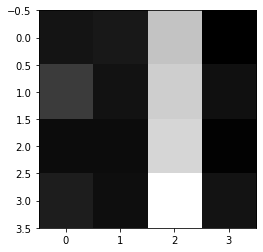

In [160]:
reconstruct_circuit = AutoencoderQuantumCircuit(3,1, layers=5, backend=backend, shots=shots)
probabilities = reconstruct_circuit.reconstruct(init_data = train_data_mini[0], 
                                                theta = opt_params,
                                                ansatz_id=9)

reconstructed_data = []
for i in range(2**data_dim):
    key = bin(i)[2:].zfill(data_dim)
    if key in probabilities[0]:
        val = probabilities[0][key]
    else:
        val = 0
    reconstructed_data.append(val)

reconstructed_data = np.array(reconstructed_data).reshape(4,4)
reconstructed_data
plt.imshow(reconstructed_data, cmap='gray')

In [140]:
# # Concentrating on the first 20 samples
# n_samples = 20

# transform  = transforms.Compose([transforms.Resize([8,8]),
#                                  transforms.ToTensor(),
#                                  transforms.ConvertImageDtype(torch.float64)])
# #transform = transforms.Compose([transforms.ToTensor()])

# X_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# # Leaving only label 1 
# idx = np.where(X_train.targets == 1)[0][:n_samples]

# X_train.data = X_train.data[idx]
# X_train.targets = X_train.targets[idx]

# train_loader = torch.utils.data.DataLoader(X_train, batch_size=32, shuffle=True)

In [144]:
# train_data = []
# for img,label in X_train:
#     train_data.append(np.array(img).reshape(64))

In [158]:
# img, label = X_train[0]
# img = img.numpy().reshape(8,8)
# print("Image shape = {}".format(img.shape))
# plt.imshow(img,cmap='gray')
# plt.show()

# train_data = img.reshape(1,-1)
# print(train_data.shape)